# Set Up Data

In [1]:
# import the required packages and preliminaries
import csv
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10})
import numpy as np
from sklearn import linear_model
from sklearn import tree
import math
import os
import time
from IPython.display import clear_output
import pickle

In [ ]:
path="/Pickles"
pickleFolder=os.getcwd()+path

In [ ]:
dataAtck=pd.read_pickle(pickleFolder+"/BaseAttackDataframe.pkl")
dataNorm=pd.read_pickle(pickleFolder+"/BaseNormalDataframe.pkl")

# New Data Transformations & Fitting Models

In [ ]:
actuator_list=["MV101","P101","P102","MV201","P201","P202","P203","P204","P205","P206","MV301","MV302","MV303","MV304","P301","P302","P401","P402","P403","P404","P501","P502","P601","P602","P603"]

In [ ]:
# General regression dataframe pickles

dataAtck_reg_adpt=pd.read_pickle(pickleFolder+"/GeneralRegressionDataframeAttack.pkl")
dataNorm_reg_adpt=pd.read_pickle(pickleFolder+"/GeneralRegressionDataframeNormal.pkl")

In [ ]:
# Linear regression dataframe pickles

AY_linreg=pd.read_pickle(pickleFolder+"/LinearRegressionDataframeAttack.pkl")
Y_linreg=pd.read_pickle(pickleFolder+"/LinearRegressionDataframeNormal.pkl")

In [ ]:
# Linear Regressors pickle

outfile=open(pickleFolder+"/LinearRegressors","rb")
d_lin=pickle.load(outfile)

# Prediction Lists and Histograms

In [ ]:
normalIndex=list(dataAtck.iloc[list(dataAtck["Normal/Attack"]=="Normal")].index)
attackIndex=list(dataAtck.iloc[list(dataAtck["Normal/Attack"]!="Normal")].index)

In [ ]:
# Normal and Attack Prediction-Observation difference lists pickles

infile=open(pickleFolder+"/NormalPredictionDifferenceList","rb")
difference_list=pickle.load(infile)
infile=open(pickleFolder+"/AttackPredictionDifferenceList","rb")
attack_difference_list=pickle.load(infile)

In [ ]:
# Normal Histogram p-Value dataframe pickle

pvalue_data=pd.read_pickle(pickleFolder+"/histogramPValueDataframe.pkl")

# Finding P-Values

In [ ]:
# Attack p-Value Dataset pickle

#attack_pvalues=pd.read_pickle(pickleFolder+"/attackPValueDataframe.pkl")
attack_diff_data=pd.DataFrame([],columns=actuator_list).copy()
for col in attack_diff_data:
    attack_diff_data[col]=attack_difference_list["diff_{0}".format(col)]
attack_diff_data.to_pickle(pickleFolder+"/attackDiffData.pkl")

In [ ]:
bin_ref_data=((attack_diff_data+4)/0.05).copy()
attack_pvalues=bin_ref_data.copy()
#rowVec=[]
for col in bin_ref_data:
    print(col)
    L=np.array([math.floor(x) for x in bin_ref_data[col]])
    for i in range(0,len(bin_ref_data)):
        try:
            if pvalue_data[col][L[i]]!=0:
                attack_pvalues[col][i]=pvalue_data[col][L[i]]
            else:
                attack_pvalues[col][i]=0.000001
        except:
            attack_pvalues[col][i]=0.000001
    #i=19
    #try:
    #    rowVec.append(pvalue_data[col][L[i]])
    #except:
    #    rowVec.append(0.00001)
attack_pvalues.to_pickle(pickleFolder+"/attackPvals.pkl")

In [2]:
path="/Pickles"
pickleFolder=os.getcwd()+path
dataAtck=pd.read_pickle(pickleFolder+"/BaseAttackDataframe.pkl")
dataNorm=pd.read_pickle(pickleFolder+"/BaseNormalDataframe.pkl")
actuator_list=["MV101","P101","P102","MV201","P201","P202","P203","P204","P205","P206","MV301","MV302","MV303","MV304","P301","P302","P401","P402","P403","P404","P501","P502","P601","P602","P603"]
dataAtck_reg_adpt=pd.read_pickle(pickleFolder+"/GeneralRegressionDataframeAttack.pkl")
dataNorm_reg_adpt=pd.read_pickle(pickleFolder+"/GeneralRegressionDataframeNormal.pkl")
AY_linreg=pd.read_pickle(pickleFolder+"/LinearRegressionDataframeAttack.pkl")
Y_linreg=pd.read_pickle(pickleFolder+"/LinearRegressionDataframeNormal.pkl")
outfile=open(pickleFolder+"/LinearRegressors","rb")
d_lin=pickle.load(outfile)
normalIndex=list(dataAtck.iloc[list(dataAtck["Normal/Attack"]=="Normal")].index)
attackIndex=list(dataAtck.iloc[list(dataAtck["Normal/Attack"]!="Normal")].index)
infile=open(pickleFolder+"/NormalPredictionDifferenceList","rb")
difference_list=pickle.load(infile)
infile=open(pickleFolder+"/AttackPredictionDifferenceList","rb")
attack_difference_list=pickle.load(infile)
pvalue_data=pd.read_pickle(pickleFolder+"/histogramPValueDataframe.pkl")
attack_diff_data=pd.read_pickle(pickleFolder+"/attackDiffData.pkl")
attack_pvalues=pd.read_pickle(pickleFolder+"/attackPvals.pkl")

In [3]:
twentySecondSum=True
fishers=False

#### Fisher's Method

In [4]:
if fishers==True:
    combinedValue=np.array([])
    for x in attack_pvalues.values:
        combinedValue=np.hstack((combinedValue,sum(np.log(x))))
    attack_pvalues["Combined"]=-2*combinedValue

#### Simes' Method

In [5]:
if fishers==False:
    mmyy=np.array([])
    for x in range(1,len(attack_pvalues.values[1])+1):
        mmyy=np.hstack((mmyy,np.array([1/x])))

    min_list=[]
    for x in attack_pvalues.values:
        min_list.append(-1*np.log(min(np.multiply(mmyy,np.sort(x)))))
    attack_pvalues["Combined"]=np.array(min_list)

#### Twenty Second Tail

In [6]:
pvalue_dataframe_combineTime=attack_pvalues.copy()
if twentySecondSum==True:
    if fishers==False:
        for t in range(0,len(attack_pvalues["Combined"])):
            pvalue_dataframe_combineTime["Combined"][t]=max(attack_pvalues["Combined"][max(0,t-19):t+1])
    if fishers==True:
        for t in range(0,len(attack_pvalues["Combined"])):
            pvalue_dataframe_combineTime["Combined"][t]=sum(attack_pvalues["Combined"][max(0,t-19):t+1])

# ROC curve

In [7]:
h=open("/home/sharding/Documents/SummerProject/Data/AttackList_Indexed.csv","r+")
file_atcklist=csv.reader(h)
top=next(file_atcklist)
attack_list=pd.DataFrame(file_atcklist)

Create attack time bins (with a tail)

In [8]:
tail=120
base=time.strptime('12/28/2015 10:00:00', '%m/%d/%Y %H:%M:%S')
attack_start_times=[]
for t in range(0,len(attack_list)):
    attack_start_times.append(int(time.mktime(time.strptime(attack_list.iloc[t][1], '%m/%d/%Y %H:%M:%S'))-time.mktime(base)))
attack_start_times=np.array(attack_start_times)
attack_end_times=[]
for t in range(0,len(attack_list)):
    attack_end_times.append(int(time.mktime(time.strptime(attack_list.iloc[t][2], '%m/%d/%Y %H:%M:%S'))-time.mktime(base)+tail))
attack_end_times=np.array(attack_end_times)
attack_bins=np.transpose(np.vstack((attack_start_times,attack_end_times)))

Give each combined pvalue a time signature

In [9]:
pvalue_dataframe_combineTime["Time"]=np.array([int(time.mktime(time.strptime(t, " %d/%m/%Y %I:%M:%S %p"))-time.mktime(base)) for t in np.array(dataAtck["Timestamp"][1:])])

Load in the dataset of times where no attacks took place

In [10]:
no_attack_true_false=(dataAtck["Normal/Attack"]=="Normal")[:-1]
no_attack_true_false[73750:74600]=np.repeat(True,len(no_attack_true_false[73750:74600]))

In [11]:
#no_attack_dataset=pd.read_pickle(pickleFolder+"/NoAttackDataset.pkl")
no_attack_dataset=pvalue_dataframe_combineTime[no_attack_true_false]

In [12]:
max(np.array(pvalue_dataframe_combineTime["Combined"]))

16.454567887579532

Create confusion matrices for all detection cut-off values, p

In [14]:
TP_array=np.array([])
FN_array=np.array([])
FP_array=np.array([])
TN_array=np.array([])

no_attack_time_list=range(0,np.array(pvalue_dataframe_combineTime["Time"])[-1]+1)
for x in attack_bins:
    no_attack_time_list=[t for t in no_attack_time_list if t<x[0] or t>x[1]]
num_no_attacks=len(no_attack_time_list)
non_detected_at_all={}
for p in np.arange(0,16.5,0.05):
    TP=0
    FN=0
    non_detected_array=np.array([])
    for x in attack_bins:
        bin_dataset=pvalue_dataframe_combineTime["Combined"][np.multiply(np.array(pvalue_dataframe_combineTime["Time"]>=x[0]),np.array(pvalue_dataframe_combineTime["Time"]<=x[1]))]
        if all(bin_dataset<p)==True:
            FN=FN+1
            non_detected_array=np.hstack((non_detected_array,x))
        else:
            TP=TP+1
    non_detected_at_all["p={0}".format(p)]=non_detected_array
    TP_array=np.hstack((TP_array,TP))
    FN_array=np.hstack((FN_array,FN))
    
    no_attack_pvalues=no_attack_dataset["Combined"]
    FP=sum(np.array(no_attack_pvalues>p))
    TN=num_no_attacks-FP
    FP_array=np.hstack((FP_array,FP))
    TN_array=np.hstack((TN_array,TN))
    clear_output(wait=True)
    print(p)

16.45


In [ ]:
with open(pickleFolder+"/notDetectedAttacks.pkl","rb") as outfile:
    not_detected=pickle.load(outfile)

In [15]:
conditionPositive=TP_array+FN_array
conditionNegative=TN_array+FP_array

In [16]:
TPR_array=TP_array/conditionPositive
FPR_array=FP_array/conditionNegative

In [17]:
folder_extension="/LINEAR/SIMES/20sTAIL"

In [18]:
with open(pickleFolder+folder_extension+'/FPR_array.pkl', 'wb') as handle:
    pickle.dump(FPR_array,handle)
with open(pickleFolder+folder_extension+'/TPR_array.pkl', 'wb') as handle:
    pickle.dump(TPR_array,handle)

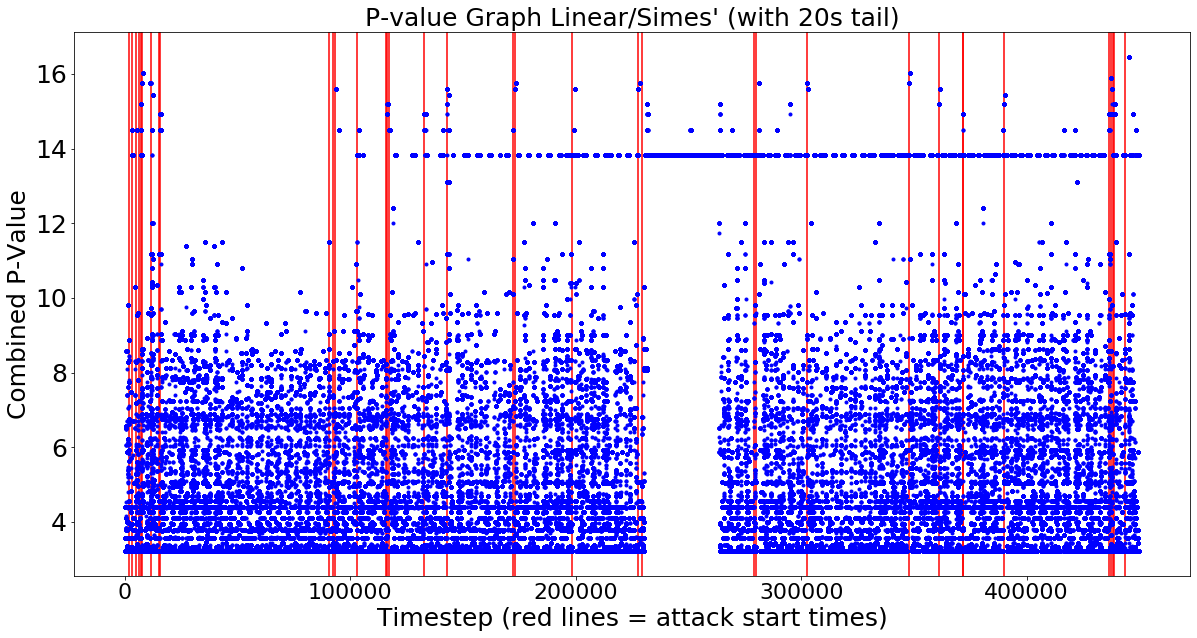

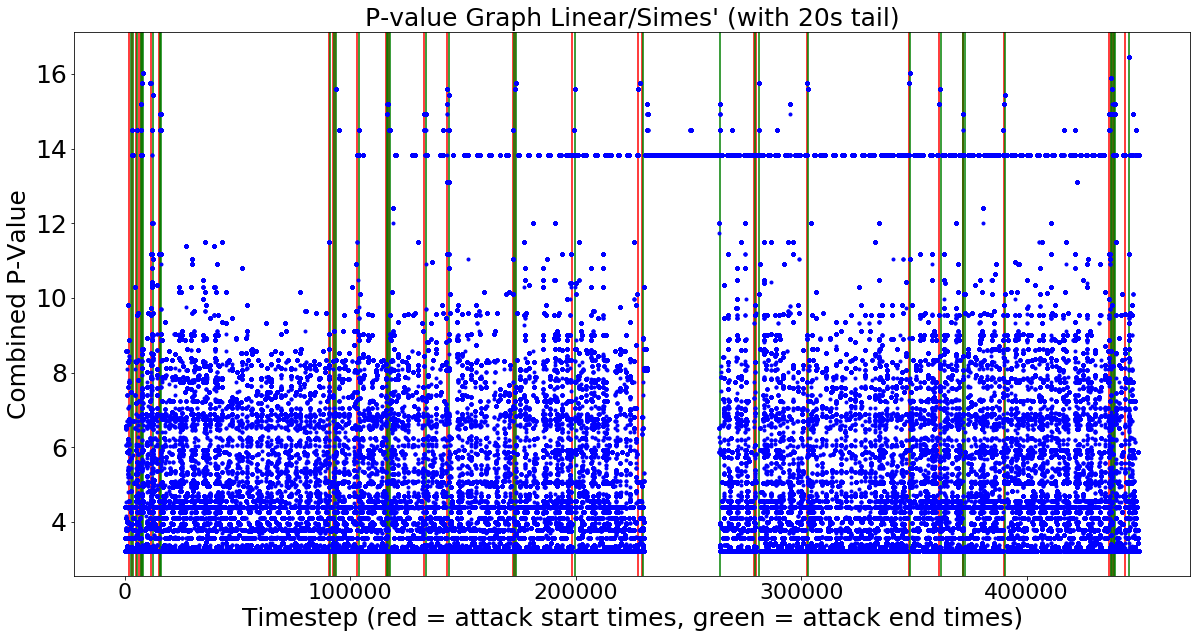

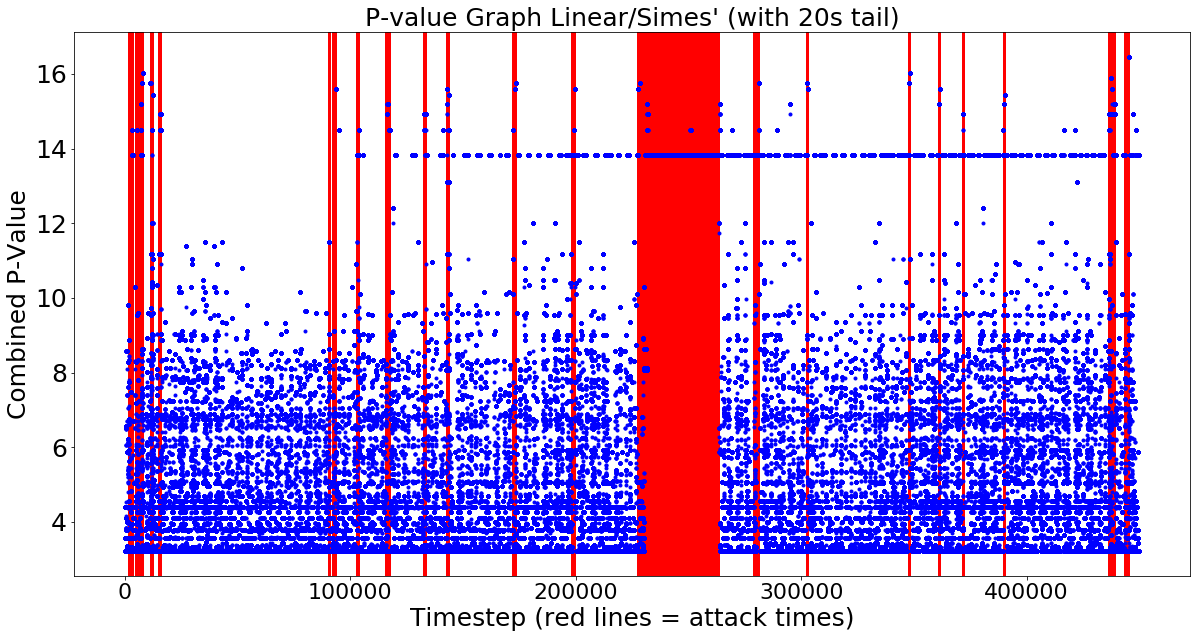

In [19]:
plt.rc('axes', titlesize=25)     # fontsize of the axes title
plt.rc('axes', labelsize=25)    # fontsize of the x and y labels
plt.rc('figure', titlesize=14)
plt.rc('xtick', labelsize=22)    # fontsize of the tick labels
plt.rc('ytick', labelsize=25)

plt.figure(figsize=(20,10))
for m in attack_start_times:
    plt.axvline(x=m,color="r",linestyle="-")

twenty_sec=np.arange(0,no_attack_time_list[-1],20)
plt.plot(pvalue_dataframe_combineTime["Time"],pvalue_dataframe_combineTime["Combined"],".b")
plt.xlabel("Timestep (red lines = attack start times)")
plt.ylabel("Combined P-Value")
plt.title("P-value Graph Linear/Simes' (with 20s tail)")
plt.savefig(pickleFolder+folder_extension+"/graph.png")
plt.show()

plt.figure(figsize=(20,10))
for m in attack_start_times:
    plt.axvline(x=m,color="r",linestyle="-")
for m in attack_end_times:
    plt.axvline(x=m,color="g",linestyle="-")
twenty_sec=np.arange(0,no_attack_time_list[-1],20)
plt.plot(pvalue_dataframe_combineTime["Time"],pvalue_dataframe_combineTime["Combined"],".b")
plt.xlabel("Timestep (red = attack start times, green = attack end times)")
plt.ylabel("Combined P-Value")
plt.title("P-value Graph Linear/Simes' (with 20s tail)")
plt.savefig(pickleFolder+folder_extension+"/graphgreen.png")
plt.show()

plt.figure(figsize=(20,10))
for m in pvalue_dataframe_combineTime["Time"][np.array([not(x) for x in no_attack_true_false])]:
    plt.axvline(x=m,color="r",linestyle="-")
twenty_sec=np.arange(0,no_attack_time_list[-1],20)
plt.plot(pvalue_dataframe_combineTime["Time"],pvalue_dataframe_combineTime["Combined"],".b")
plt.xlabel("Timestep (red lines = attack times)")
plt.ylabel("Combined P-Value")
plt.title("P-value Graph Linear/Simes' (with 20s tail)")
plt.savefig(pickleFolder+folder_extension+"/graphlefthand.png")
plt.show()

Text(0.5, 1, "ROC curve Linear/Simes' (with 20s tail)")

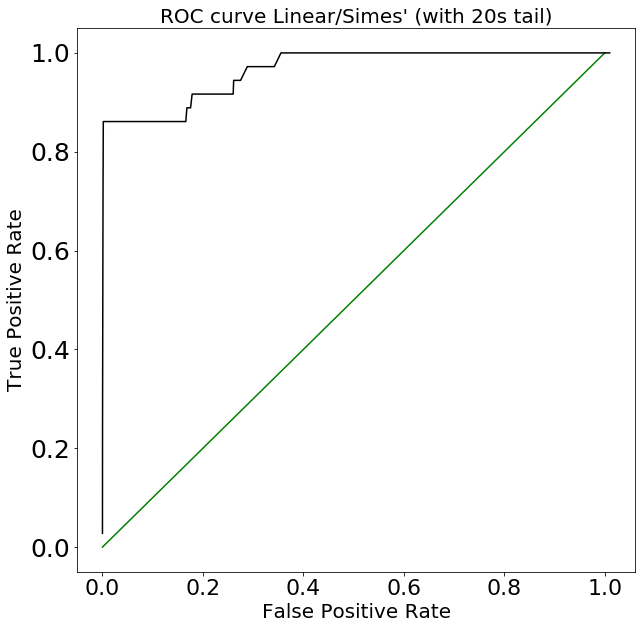

In [20]:
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('figure', titlesize=10)

plt.figure(figsize=(10,10))
plt.plot(np.arange(0,1,0.0001),np.arange(0,1,0.0001),"g")
plt.plot(FPR_array,TPR_array,"k")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.savefig(pickleFolder+folder_extension+"/roc.png")
plt.title("ROC curve Linear/Simes' (with 20s tail)")